In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from tqdm import tqdm


In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80) 
  
# data (as pandas dataframes) 
X = optical_recognition_of_handwritten_digits.data.features 
y = optical_recognition_of_handwritten_digits.data.targets 
  
# metadata 
print(optical_recognition_of_handwritten_digits.metadata) 
  
# variable information 
print(optical_recognition_of_handwritten_digits.variables) 


{'uci_id': 80, 'name': 'Optical Recognition of Handwritten Digits', 'repository_url': 'https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits', 'data_url': 'https://archive.ics.uci.edu/static/public/80/data.csv', 'abstract': 'Two versions of this database available; see folder', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 5620, 'num_features': 64, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Wed Aug 23 2023', 'dataset_doi': '10.24432/C50P49', 'creators': ['E. Alpaydin', 'C. Kaynak'], 'intro_paper': {'ID': 280, 'type': 'NATIVE', 'title': 'Methods of Combining Multiple Classifiers and Their Applications to Handwritten Digit Recognition', 'authors': 'C. Kaynak', 'venue': 'MSc Thesis, Institute of Graduate Studies in Science and Engineering, 

Epoch 1/20, Train Loss: 2.1157, Train Acc: 36.32%, Test Loss: 1.4974, Test Acc: 70.55%
Epoch 2/20, Train Loss: 0.8261, Train Acc: 78.78%, Test Loss: 0.4220, Test Acc: 88.61%
Epoch 3/20, Train Loss: 0.3617, Train Acc: 88.77%, Test Loss: 0.2478, Test Acc: 93.15%
Epoch 4/20, Train Loss: 0.2635, Train Acc: 92.08%, Test Loss: 0.1983, Test Acc: 94.31%
Epoch 5/20, Train Loss: 0.2037, Train Acc: 94.02%, Test Loss: 0.1673, Test Acc: 95.73%
Epoch 6/20, Train Loss: 0.1603, Train Acc: 95.13%, Test Loss: 0.1506, Test Acc: 96.00%
Epoch 7/20, Train Loss: 0.1432, Train Acc: 95.71%, Test Loss: 0.1182, Test Acc: 96.26%
Epoch 8/20, Train Loss: 0.1248, Train Acc: 96.15%, Test Loss: 0.1175, Test Acc: 96.62%
Epoch 9/20, Train Loss: 0.1087, Train Acc: 96.71%, Test Loss: 0.1070, Test Acc: 96.89%
Epoch 10/20, Train Loss: 0.1037, Train Acc: 97.00%, Test Loss: 0.0894, Test Acc: 97.33%
Epoch 11/20, Train Loss: 0.0866, Train Acc: 97.33%, Test Loss: 0.0927, Test Acc: 97.42%
Epoch 12/20, Train Loss: 0.0834, Train Ac

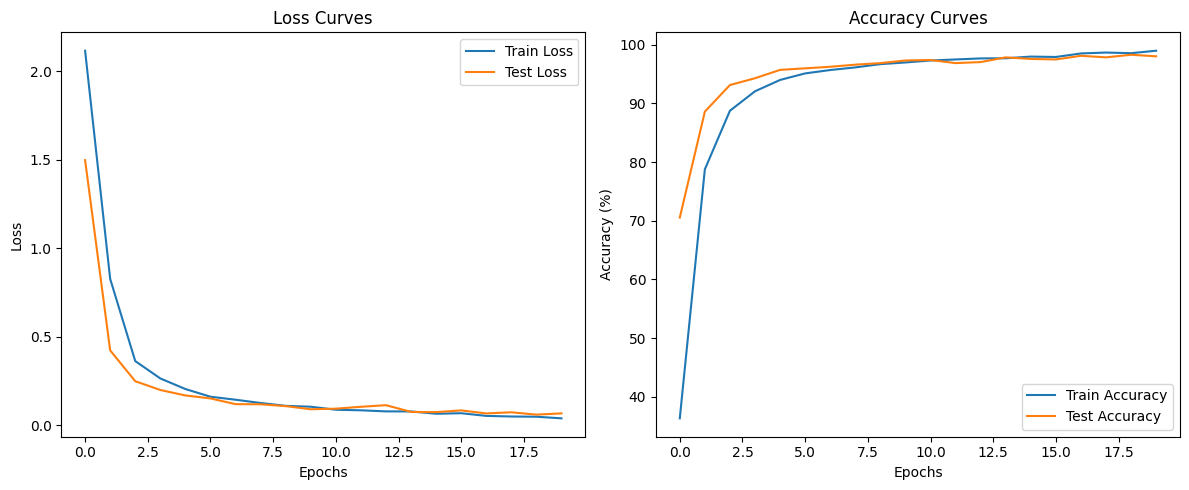

Final Test Accuracy: 98.04%


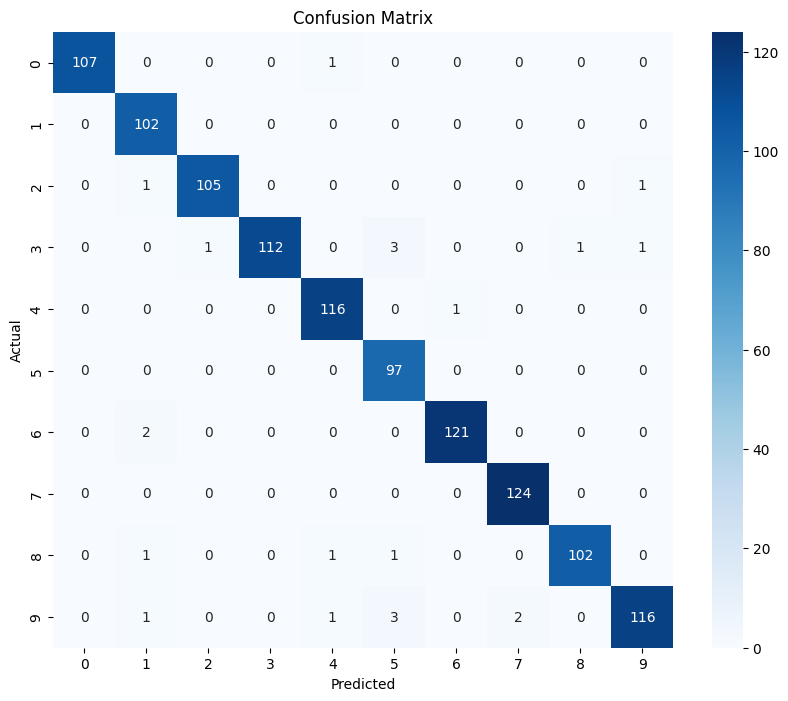


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       108
           1       0.95      1.00      0.98       102
           2       0.99      0.98      0.99       107
           3       1.00      0.95      0.97       118
           4       0.97      0.99      0.98       117
           5       0.93      1.00      0.97        97
           6       0.99      0.98      0.99       123
           7       0.98      1.00      0.99       124
           8       0.99      0.97      0.98       105
           9       0.98      0.94      0.96       123

    accuracy                           0.98      1124
   macro avg       0.98      0.98      0.98      1124
weighted avg       0.98      0.98      0.98      1124



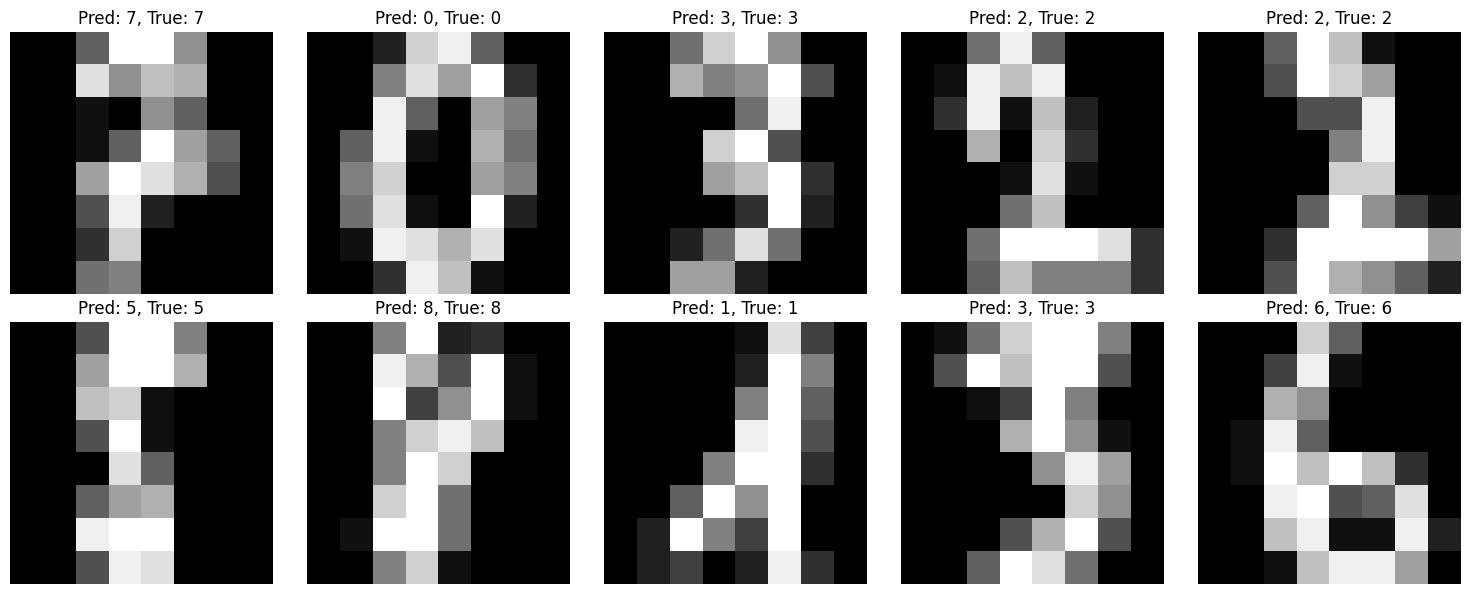

Model saved to 'uci_digit_cnn_model.pth'


In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Use the already fetched dataset
# X and y are already available as pandas DataFrames
# Convert to numpy arrays
X_numpy = X.values.astype(np.float32)
y_numpy = y.values.flatten().astype(np.int64)
# Normalize the data
X_numpy = (X_numpy - X_numpy.min()) / (X_numpy.max() - X_numpy.min())

# Reshape data to include channel dimension for CNN (batch_size, channels, height, width)
X_numpy = X_numpy.reshape(-1, 1, 8, 8)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_numpy, y_numpy, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create Dataset and DataLoader
class DigitDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets and dataloaders
train_dataset = DigitDataset(X_train_tensor, y_train_tensor)
test_dataset = DigitDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the CNN model
class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()
        # First convolutional layer: 1 input channel, 16 output channels
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        # Second convolutional layer: 16 input channels, 32 output channels
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes (digits 0-9)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        # First conv block: Conv + ReLU + MaxPool
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # 8x8 -> 4x4
        
        # Second conv block: Conv + ReLU + MaxPool
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # 4x4 -> 2x2
        
        # Flatten the tensor
        x = x.view(-1, 32 * 2 * 2)
        
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DigitCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to train the model
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Calculate loss
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Accumulate loss
        train_loss += loss.item()
        
        # Calculate accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    
    return train_loss / len(train_loader), 100. * correct / total

# Function to evaluate the model
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            
            # Calculate loss
            loss = criterion(output, target)
            
            # Accumulate loss
            test_loss += loss.item()
            
            # Calculate accuracy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            
            # Store predictions and targets for confusion matrix
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    return test_loss / len(test_loader), 100. * correct / total, all_preds, all_targets

# Train the model
epochs = 20
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(epochs):
    # Train the model
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate the model
    test_loss, test_acc, all_preds, all_targets = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Plot training and validation curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curves')
plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_acc, all_preds, all_targets = evaluate(model, test_loader, criterion, device)
print(f"Final Test Accuracy: {test_acc:.2f}%")

# Create confusion matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(all_targets, all_preds))

# Visualize some examples with predictions
def visualize_predictions(model, test_loader, device, num_samples=10):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"Pred: {preds[i].item()}, True: {labels[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show some predictions
visualize_predictions(model, test_loader, device)

# Save the model
torch.save(model.state_dict(), 'uci_digit_cnn_model.pth')
print("Model saved to 'uci_digit_cnn_model.pth'")